<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
# #finding EL2O by minimization
# tf.reset_default_graph()

# batch_size  = 64
# hidden_size = 8

# def inference(in_net):
#     with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
#     return net

# def generator(in_net):
#     with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 784, name='dense_5', activation=None)
#     return net

# lr    = tf.placeholder_with_default(0.001,shape=[])

# x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

# prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

# mu, sigma        = tf.split(inference(x), 2, axis=-1)
# sigma            = tf.nn.softplus(sigma) + 0.0001
# approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

# z                = approx_posterior.sample()

# sample_size      = tf.placeholder_with_default(100,shape=[])

# z_samples        = approx_posterior.sample(sample_size)

# x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

# x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

# data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

# kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

# elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

# with tf.variable_scope("posteriorELBO"):
#     mu_elbo    = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
#     sigma_elbo = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
# sigma_t_elbo = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_elbo), transform=tf.nn.softplus)

# approx_posterior_elbo = tfd.MultivariateNormalTriL(loc=mu_elbo,scale_tril=sigma_t_elbo, name='posteriorELBO')


# with tf.variable_scope("posteriorEL2O"):
#     mu_el2 = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
#     sigma_el2 = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
# sigma_t_el2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_el2), transform=tf.nn.softplus)

# approx_posterior_el2o = tfd.MultivariateNormalTriL(loc=mu_el2,scale_tril=sigma_t_el2, name='posteriorEL2O')

# z_sample_elbo     = approx_posterior_elbo.sample()

# z_sample_el2o     = approx_posterior_el2o.sample()

# zmean_elbo        = approx_posterior_elbo.mean()

# zmean_el2o        = approx_posterior_el2o.mean()

# likeli_zmean_elbo = tfd.Independent(tfd.Bernoulli(logits=generator(zmean_elbo)))

# likeli_zmean_el2o = tfd.Independent(tfd.Bernoulli(logits=generator(zmean_el2o)))

# kl_divergence_elbo= tfd.kl_divergence(approx_posterior_elbo, prior) 

# mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])

# zz                = tf.identity(z_sample_el2o)

# elbo_logits       = tf.boolean_mask(generator(z_sample_elbo), mymask, axis=1)

# el2o_logits       = tf.boolean_mask(generator(zz), mymask, axis=1)

# data_likelihood_elbo = tfd.Independent(tfd.Bernoulli(logits=elbo_logits))

# data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))

# masked_data       = tf.boolean_mask(x, mymask, axis=1)
    
# mask_elbo         = -tf.reduce_mean(data_likelihood_elbo.log_prob(masked_data)- kl_divergence_elbo,axis=0)

# mask_post         = - tf.reduce_mean(prior.log_prob(zz)) - tf.reduce_mean(data_likelihood_el2o.log_prob(masked_data))

# mask_post_approx  = - approx_posterior_el2o.log_prob(zz)

# dptdz             = tf.gradients(mask_post,zz) 
# dptdz             = tf.gather(dptdz, 0)

# dpdz              = tf.gradients(mask_post_approx,zz) 
# dpdz              = tf.gather(dpdz, 0)

# hesst             = tf.hessians(mask_post, zz)
# hesst             = tf.gather(hesst, 0)
# hesst2            = tf.reduce_sum( hesst, axis = -1 )
# lowt              = tf.matrix_band_part(hesst2, -1, 0)

# hess              = tf.hessians(mask_post_approx, zz)
# hess              = tf.gather(hess, 0)
# hess2             = tf.reduce_sum(hess, axis = -1 )
# lowt2             = tf.matrix_band_part(hess2, -1, 0)

# mask_el2o         = tf.reduce_mean(tf.math.square(dpdz-dptdz))+tf.reduce_mean(tf.math.square((lowt-lowt2)))

# z_samples_elbo    = approx_posterior_elbo.sample(sample_size)

# x_samples_elbo    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).sample(sample_size)

# z_samples_el2o    = approx_posterior_el2o.sample(sample_size)

# x_samples_el2o    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_el2o))).sample(sample_size)

In [7]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size  = 256
batch_size2 = 1
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z                = approx_posterior.sample()

sample_size      = tf.placeholder_with_default(1,shape=[])

z_samples        = approx_posterior.sample(sample_size)

x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("approxposterior2",reuse=True):
  mu_new      = tf.Variable(np.ones((1,hidden_size))*10., dtype=np.float32)
  sigma_new   = tf.Variable(np.ones((1,hidden_size))*4., dtype=np.float32)
  
#idellay I wanna have a loop where mu_new and sigma_new get updated
approx_posterior2 = tfd.MultivariateNormalDiag(loc=mu_new,scale_diag=sigma_new, name='approxposterior2')

update1           = tf.assign(mu_new,tf.expand_dims(tf.gather(mu,0),0))

update2           = tf.assign(sigma_new,tf.expand_dims(tf.gather(sigma,0),0))

zz                = approx_posterior2.sample()
shape1            = tf.shape(zz)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
xx                = tf.identity(zz)
el2o_logits       = tf.boolean_mask(generator(xx), mymask, axis=1)
shape2            = tf.shape(el2o_logits)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
x_corr            = tf.placeholder(shape=[784], dtype=tf.float32)
m_data            = tf.boolean_mask(x_corr, mymask)
p_of_z            = -prior.log_prob(xx)-data_likelihood_el2o.log_prob(m_data)##
shape3            = tf.shape(p_of_z)
p_of_z            = tf.gather(p_of_z,0)
shape4            = tf.shape(p_of_z)
dpdz              = tf.gradients(p_of_z, xx) 
dpdz              = tf.gather(dpdz, 0)
dpdzz             = tf.gradients(dpdz,xx)
dpdzz             = tf.gather(dpdzz, 0)
sigma2            = tf.sqrt(tf.square(tf.math.reciprocal(dpdzz)))
sigma_n           = tf.math.sqrt(sigma2)
mu_n              = -tf.einsum('ij,ij->ij', sigma2,dpdz)+xx
update3           = tf.assign(mu_new,mu_n)
update4           = tf.assign(sigma_new,sigma_n)

z_samples_el2o    = approx_posterior2.sample(sample_size)

x_samples_el2o    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_el2o))).sample(sample_size)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:
#opt_op2a= optimizer.minimize(mask_elbo,var_list=[mu_elbo,sigma_elbo])

#opt_op2b= optimizer.minimize(mask_el2o,var_list=[mu_el2,sigma_el2])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [12]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [13]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-3
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 236.95203 225.98811 0.0
0 214.44318 212.18436 0.0
0 211.45813 205.84167 0.0
0 207.5043 188.62645 0.0
0 206.67986 188.78525 0.0
0 199.62279 186.57033 0.0
0 191.73329 184.2946 0.0
0 190.67616 184.8783 0.0
0 188.9408 179.62978 0.0
0 179.08122 170.5333 0.0
0 172.2508 165.90283 0.0
0 171.51913 163.62634 0.0
0 171.01099 154.8649 0.0
0 170.4438 157.31961 0.0
0 167.30789 158.99152 0.0
0 163.1881 145.77568 0.0
0 155.85164 148.56544 0.0
0 150.71884 146.3967 0.0
0 161.30345 138.61163 0.0
new epoch
1 153.67351 140.24048 0.0
1 154.20328 144.06207 0.0
1 152.57227 143.73962 0.0
1 152.73175 135.61354 0.0
1 151.88454 134.79489 0.0
1 153.25548 132.21677 0.0
1 152.85794 137.04091 0.0
1 150.40616 142.02301 0.0
1 149.91641 138.67772 0.0
1 147.40512 136.41443 0.0
1 151.34406 134.37381 0.0
1 141.45447 136.92583 0.0
1 144.02136 132.0167 0.0
1 140.70424 134.16338 0.0
1 144.80922 137.78511 0.0
1 144.69955 125.18577 0.0
1 143.74744 129.77463 0.0
1 140.9422 128.82288 0.0
1 140.00409 122.5164 0.0
new e

KeyboardInterrupt: ignored

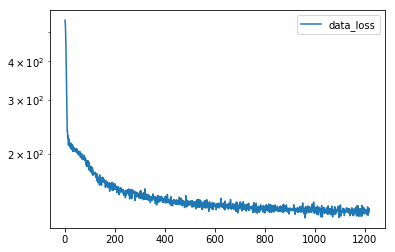

In [14]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z_samples, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

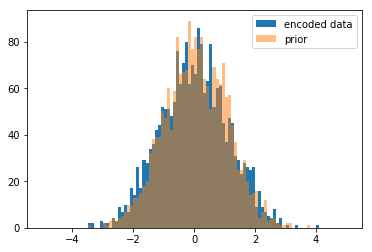

In [16]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 360x360 with 0 Axes>

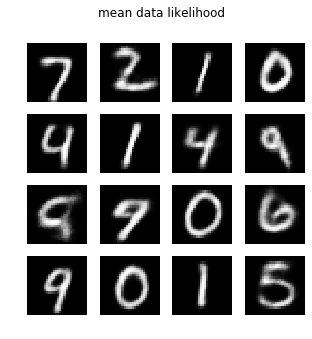

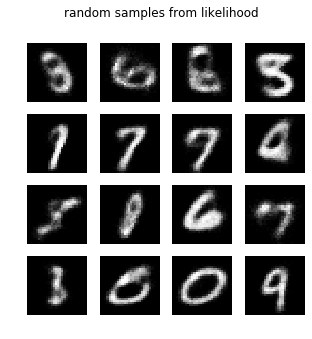

In [17]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_test[0:batch_size], sample_size: 100})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

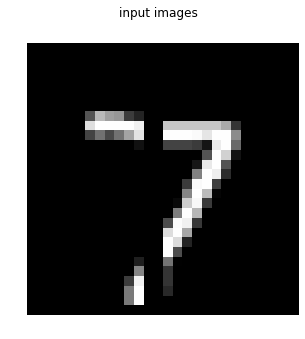

In [63]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,12:14]=0.
mask = mask.reshape((28*28))

#mask = np.asarray([mask]*batch_size)
masked_data = x_test[0]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask = mask.reshape((28*28))


figure(figsize=(5,5))
suptitle('input images')
for i in range(1):
    subplot(1,1,i+1)
    imshow(masked_data.reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [64]:
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])

[0.18349133 0.09503159 0.15842229 0.11231325 0.22282185 0.16121906
 0.21784668 0.08822463]
[0.27375    0.11097156 0.16756123 0.13145827 0.28342986 0.26513785
 0.23535264 0.09523567]
[ 0.29456776  0.35255235  2.306435   -0.2138356   0.416307    0.6389077
  0.97872406 -0.7365344 ]
[ 2.0655262  -0.48777765  1.1346701  -1.5265465  -0.01162672  1.4324223
  0.25486743  0.27574164]


In [65]:
sess.run([mu_n, sigma_n, shape1, shape2,shape3,shape4], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})

[array([[ 1.91961   , -0.53331643,  0.802734  , -1.4286938 , -0.23933545,
          1.1194422 , -0.20211563,  0.34087503]], dtype=float32),
 array([[0.2231751 , 0.1400494 , 0.18655469, 0.1230664 , 0.22628509,
         0.26822555, 0.2632581 , 0.08312427]], dtype=float32),
 array([1, 8], dtype=int32),
 array([  1, 784], dtype=int32),
 array([1], dtype=int32),
 array([], dtype=int32)]

In [66]:
sess.run([dpdz,dpdzz], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], mymask: mask})

[array([[  32.27619  , -110.765305 ,  -10.915742 ,  -90.06741  ,
           10.67746  ,   16.805021 ,    4.2027764,  106.54213  ]],
       dtype=float32),
 array([[ 24.264496 ,  63.955666 ,  22.152391 ,  67.23999  ,  18.532373 ,
           5.3971367,  18.651955 , 138.23936  ]], dtype=float32)]

In [67]:
_, _=sess.run([update1,update2], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new], feed_dict={x_corr:masked_data, x: x_train[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])


[0.18349133 0.09503159 0.15842229 0.11231325 0.22282185 0.16121906
 0.21784668 0.08822463]
[0.18349133 0.09503159 0.15842229 0.11231325 0.22282185 0.16121906
 0.21784668 0.08822463]
[ 0.29456776  0.35255235  2.306435   -0.2138356   0.416307    0.6389077
  0.97872406 -0.7365344 ]
[ 0.29456776  0.35255235  2.306435   -0.2138356   0.416307    0.6389077
  0.97872406 -0.7365344 ]


In [68]:
sess.run([mu_n, sigma_n, shape1], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})

[array([[ 1.3998414 , -0.0154604 ,  1.4452434 , -0.65402794,  0.01236835,
          2.5590873 ,  0.728966  , -0.40991127]], dtype=float32),
 array([[0.1761225 , 0.07692652, 0.13263254, 0.10019305, 0.42300686,
         0.25458723, 0.24396926, 0.08401358]], dtype=float32),
 array([1, 8], dtype=int32)]

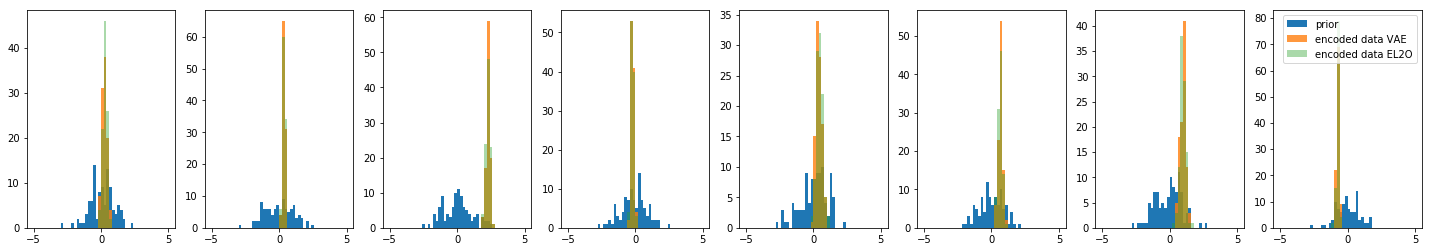

In [69]:
res3 = sess.run(z_samples_el2o,feed_dict={x_corr: masked_data, x: x_train[0:batch_size], sample_size:100, mymask: mask})
res2 = sess.run(z_samples,feed_dict={x_corr: masked_data, x: x_train[0:batch_size], sample_size:100, mymask: mask})
res2 = res2[:,0,:]
res3 = res3[:,0,:]
f=plt.figure()
f.set_figheight(4)
f.set_figwidth(25)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  hist(randn(len(res2[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
  hist(res2[:,ii].flatten(),50,range=[-5,5],alpha=0.8, label='encoded data VAE');
  hist(res3[:,ii].flatten(),50,range=[-5,5],alpha=0.4,label='encoded data EL2O');
legend()

In [70]:
sess.run([dpdz,dpdzz,sigma2],feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})

[array([[-3.4417320e+01,  4.8024883e+01,  4.6190540e+01,  3.6259727e+01,
         -3.5200715e-03, -2.0553757e+01,  2.7476296e+00, -4.9641151e+01]],
       dtype=float32),
 array([[ 43.775326 , 183.61201  ,  76.488304 , 102.57473  , -14.4039955,
          19.422932 ,  28.984922 , 143.22876  ]], dtype=float32),
 array([[0.02284392, 0.00544627, 0.01307389, 0.00974899, 0.06942518,
         0.05148553, 0.0345007 , 0.00698184]], dtype=float32)]

In [77]:
_, _=sess.run([update3,update4],feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new],feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], mymask: mask})

print(c[0]-c1[0])
print(m[0]-m1[0])

[-0.09573252 -0.04374023 -0.13042039 -0.07732657  0.00553611 -0.09188139
 -0.49669576 -0.02235022]
[-3.422435    1.1411488   1.2172282   1.6749002   0.44791123 -1.7526586
  0.26645738 -0.73830676]


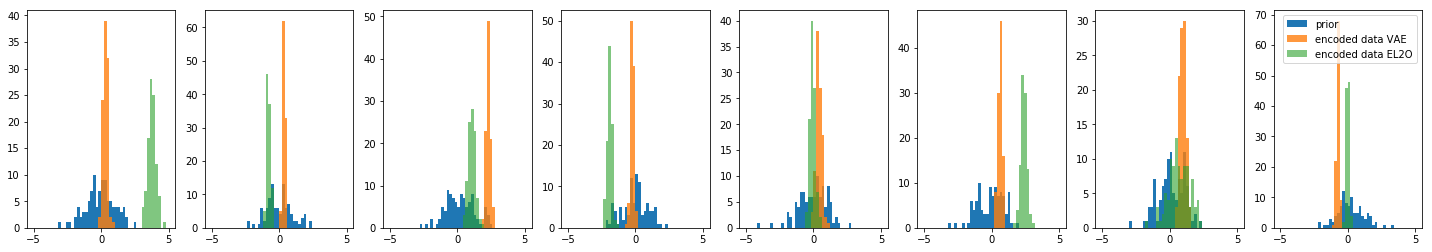

In [78]:
res3 = sess.run(z_samples_el2o,feed_dict={x_corr: masked_data, x: x_train[0:batch_size], sample_size:100, mymask: mask})
res2 = sess.run(z_samples,feed_dict={x_corr: masked_data, x: x_train[0:batch_size], sample_size:100, mymask: mask})
res2 = res2[:,0,:]
res3 = res3[:,0,:]
f=plt.figure()
f.set_figheight(4)
f.set_figwidth(25)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  hist(randn(len(res2[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
  hist(res2[:,ii].flatten(),50,range=[-5,5],alpha=0.8, label='encoded data VAE');
  hist(res3[:,ii].flatten(),50,range=[-5,5],alpha=0.6,label='encoded data EL2O');
legend()

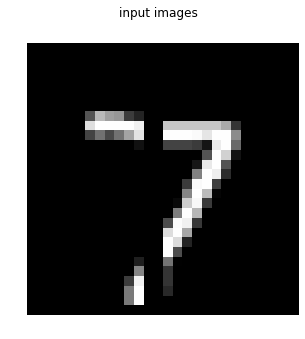

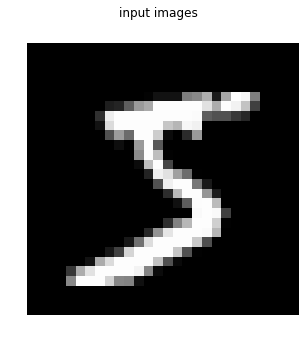

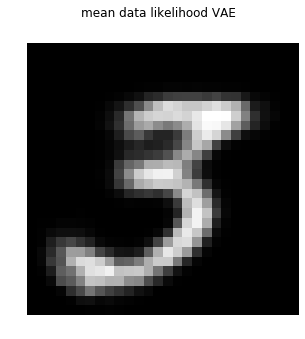

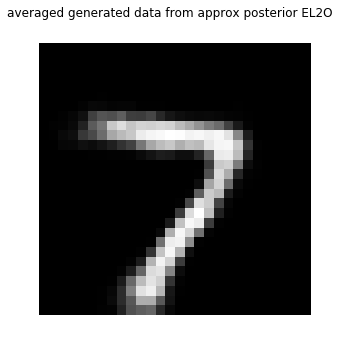

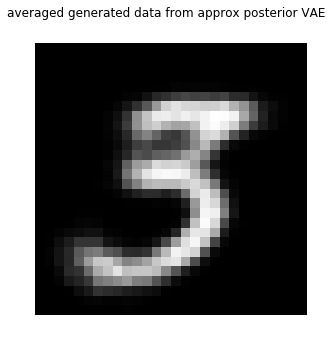

In [79]:
inim, xrecons2 = sess.run([x, x_samples_el2o], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], sample_size:40, mymask: mask})
xmean, xrecon  = sess.run([data_likelihood.mean(),x_samples], feed_dict={x_corr:masked_data, x: x_train[0:batch_size], sample_size:40, mymask: mask})

figure(figsize=(5,5))
suptitle('input images')
for i in range(1):
    subplot(1,1,i+1)
    imshow(masked_data.reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('input images')
for i in range(1):
    subplot(1,1,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(1):
    subplot(1,1,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')




    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior EL2O')
for i in range(1):
    subplot(1,1,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(1):
    subplot(1,1,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [43]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

(256, 784)
